In [236]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os

import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


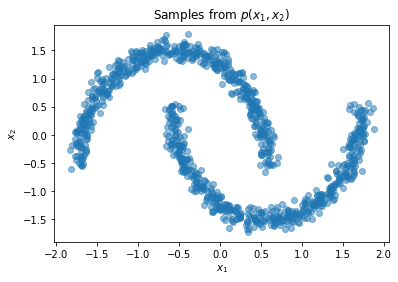

/Users/druhe/Projects/gw/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/druhe/Projects/gw/.venv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


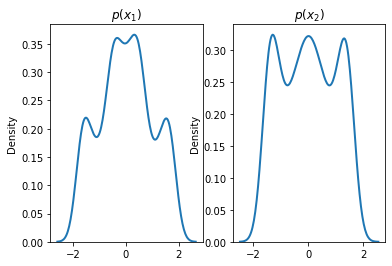

In [237]:
n_samples = 1000
X, y = datasets.make_moons(n_samples=n_samples, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()


In [238]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, spline_transform)


In [239]:
steps = 5000
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


step: 0, loss: 5.638874530792236
step: 500, loss: 1.2083303928375244


KeyboardInterrupt: 

In [229]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
# planar_transform = nn.ModuleList([PlanarWithLogProb(2) for _ in range(8)])
transform = T.ComposeTransform([T.planar(2) for _ in range(16)])
flow_dist = dist.TransformedDistribution(base_dist, [transform.inv])
trainable_modules = nn.ModuleList([t for t in transform.parts if isinstance(t, nn.Module)])
# flow_dist = dist.TransformedDistribution(base_dist, [t.inv for t in planar_transform])



In [230]:
# X = torch.randn(1024, 2) + 3

In [231]:
steps = 5000
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(trainable_modules.parameters(), lr=1e-2)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    for t in transform.parts:
        t.clear_cache()
#     transform.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))


/var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/ipykernel_9440/1348466648.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(X, dtype=torch.float)


step: 0, loss: 6.518523216247559
step: 500, loss: 3.710582971572876
step: 1000, loss: 3.66231369972229
step: 1500, loss: 3.6449553966522217
step: 2000, loss: 3.6355903148651123
step: 2500, loss: 3.6309309005737305
step: 3000, loss: 3.6284799575805664
step: 3500, loss: 3.627903938293457
step: 4000, loss: 3.62603759765625
step: 4500, loss: 3.623922348022461
step: 5000, loss: 3.62636661529541


In [232]:
rng = torch.linspace(-3, 3, 128)

X = torch.stack(torch.meshgrid(rng, rng, indexing='xy'), dim=0).view(2, -1).T

In [234]:
prob = flow_dist.log_prob(X).exp()

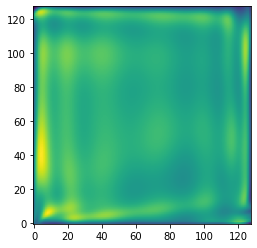

In [235]:
plt.imshow(prob.view(128, 128).detach(), origin='lower')